In [16]:
import os
import cv2
import copy
import time
import math
import random
import datetime
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Dict, List, Optional, Tuple

import utils

In [2]:
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\citak\\Desktop\\RoadAnalysis\\utils.py'>

### Available Classes ###

D00 - Longitudinal Crack<br>
D10 - Transverse Crack<br>
D20 - Alligator Crack<br>
D40 - Pothole<br>
D43 - Repair<br>
D44 - White Line Disconnection<br>
D50 - Bleeding<br>

In [3]:
## Sample Analysis
sample_idx = 6
sample_idx = str(sample_idx).zfill(6)

annot_path = r"C:\RDD2022\RDD2022\Czech\train\annotations\xmls\Czech_"+sample_idx+".xml"
image_path = r"C:\RDD2022\RDD2022\Czech\train\images\Czech_"+sample_idx+".jpg"

annot_data = utils.parse_annotation(annot_path)
print(annot_data.keys())

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

dict_keys(['folder', 'filename', 'size', 'objects'])
(600, 600, 3)


In [4]:
annot_data["objects"]

[{'name': 'D00',
  'bndbox': {'xmin': 141, 'ymin': 405, 'xmax': 166, 'ymax': 472}}]

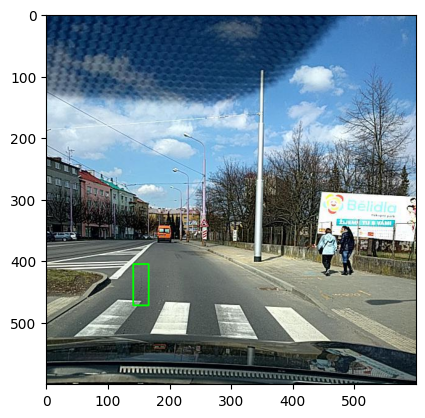

In [5]:
color_map = {'D00':(0,255,0), 'D10':(255,0,0), 'D20':(0,0,255), 'D40':(125,125,0), 'D43':(0,125,125), 'D44':(125,0,125), 'D50':(65,65,65)}

for annot_object in annot_data["objects"]:
    name = annot_object['name']

    bbox = annot_object['bndbox']
    x1, x2, y1, y2 = bbox['xmin'], bbox['xmax'], bbox['ymin'], bbox['ymax']

    cv2.rectangle(image, (x1,y1), (x2,y2), color_map[name], 2)



plt.imshow(image)

In [6]:
### Loop over entire dataset and gather the overall information 
ds_main_path = 'C:\RDD2022\RDD2022'
countries = [os.path.join(ds_main_path, country) for country in os.listdir(ds_main_path)]
print(countries)

['C:\\RDD2022\\RDD2022\\China_Drone', 'C:\\RDD2022\\RDD2022\\China_MotorBike', 'C:\\RDD2022\\RDD2022\\Czech', 'C:\\RDD2022\\RDD2022\\India', 'C:\\RDD2022\\RDD2022\\Japan', 'C:\\RDD2022\\RDD2022\\Norway', 'C:\\RDD2022\\RDD2022\\United_States']


In [7]:
all_names = dict()
n_annots = 0
n_objects = 0
n_annot_wout_object = 0

for country_path in tqdm(countries, total=len(countries)):
    country_annot_path = os.path.join(country_path, 'train')
    country_annot_path = os.path.join(country_annot_path, 'annotations')
    country_annot_path = os.path.join(country_annot_path, 'xmls')

    print(country_annot_path)

    annot_files_paths =  [os.path.join(country_annot_path, annot_file) for annot_file in os.listdir(country_annot_path)]

    for annot_file_path in tqdm(annot_files_paths):
        annot_data = utils.parse_annotation(annot_file_path)
        n_annots += 1

        if len(annot_data["objects"]) == 0:
            n_annot_wout_object += 1
        else:
            n_objects += len(annot_data["objects"])
            
            for annot_object in annot_data["objects"]:
                name = annot_object['name']

                if name not in all_names.keys():
                    all_names[name] = 1
                else:
                    all_names[name] = all_names[name] + 1

  0%|          | 0/7 [00:00<?, ?it/s]

C:\RDD2022\RDD2022\China_Drone\train\annotations\xmls


 14%|█▍        | 1/7 [00:00<00:01,  4.85it/s]

C:\RDD2022\RDD2022\China_MotorBike\train\annotations\xmls


 29%|██▊       | 2/7 [00:00<00:01,  4.93it/s]

C:\RDD2022\RDD2022\Czech\train\annotations\xmls


 43%|████▎     | 3/7 [00:00<00:00,  4.94it/s]

C:\RDD2022\RDD2022\India\train\annotations\xmls


 57%|█████▋    | 4/7 [00:01<00:01,  2.79it/s]

C:\RDD2022\RDD2022\Japan\train\annotations\xmls


 71%|███████▏  | 5/7 [00:02<00:01,  1.68it/s]

C:\RDD2022\RDD2022\Norway\train\annotations\xmls


 86%|████████▌ | 6/7 [00:02<00:00,  1.60it/s]

C:\RDD2022\RDD2022\United_States\train\annotations\xmls


100%|██████████| 7/7 [00:03<00:00,  2.08it/s]


In [8]:
n_annots, n_objects, n_annot_wout_object

(38385, 65712, 11724)

In [9]:
all_names

{'D10': 11830,
 'D00': 26016,
 'D20': 10617,
 'Repair': 1046,
 'D40': 6544,
 'Block crack': 3,
 'D44': 5057,
 'D01': 179,
 'D11': 45,
 'D50': 3581,
 'D43': 793,
 'D0w0': 1}

In [10]:
sum(list(all_names.values()))

65712

In [11]:
n_annots + n_annot_wout_object

50109

#### DS path creation; train, validation and test

In [14]:
def split_data(paths, val_ratio=0.1, test_ratio=0.1):
    # Shuffle the list
    random.shuffle(paths)

    # Compute split sizes
    total = len(paths)
    val_size = int(total * val_ratio)
    test_size = int(total * test_ratio)
    train_size = total - val_size - test_size

    # Split the dataset
    train_paths = paths[:train_size]
    val_paths = paths[train_size:train_size + val_size]
    test_paths = paths[train_size + val_size:]

    return train_paths, val_paths, test_paths

In [12]:
### For all the annotations, filter the interested classes then save them with their paths
###  to the csv files.
interested_classes = ['D00', 'D10', 'D20', 'D40', 'D43', 'D44', 'D50']
all_annot_paths = list()

for country_path in tqdm(countries, total=len(countries)):
    country_annot_path = os.path.join(country_path, 'train')
    country_annot_path = os.path.join(country_annot_path, 'annotations')
    country_annot_path = os.path.join(country_annot_path, 'xmls')

    annot_files_paths =  [os.path.join(country_annot_path, annot_file) for annot_file in os.listdir(country_annot_path)]

    for annot_file_path in tqdm(annot_files_paths):
        annot_data = utils.parse_annotation(annot_file_path)
        n_annot_object = len(annot_data["objects"])

        # if there is no object inside of the annot data,
        #  just pass
        if n_annot_object == 0:
            continue
        else:
            interested_annot_path = False

            for annot_object in annot_data["objects"]:
                name = annot_object['name']

                if name in interested_classes:
                    interested_annot_path = True
                    break
            
            if interested_annot_path:
                all_annot_paths.append(annot_file_path)


print('Total Interested Annotated Images: {}'.format(len(all_annot_paths)))

100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

Total Interested Annotated Images: 26057


In [15]:
train, val, test = split_data(all_annot_paths)

# Check sizes
print(f"Train: {len(train)}, Validation: {len(val)}, Test: {len(test)}")

Train: 20847, Validation: 2605, Test: 2605


In [17]:
## save the train, validation, and test list to the proper csv files
def save_to_csv(file_name, data):
    df = pd.DataFrame(data, columns=["path"])
    df.to_csv(file_name, index=False)

# Save to CSV
save_to_csv("train_paths.csv", train)
save_to_csv("val_paths.csv", val)
save_to_csv("test_paths.csv", test)

print("CSV files saved successfully!")

CSV files saved successfully!
